In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ann challenge

Mounted at /content/drive
/content/drive/My Drive/ann challenge


### Import libraries

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [4]:
# Import other libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle
from tqdm.notebook import trange, tqdm
import seaborn as sns
plt.rc('font', size=16)
sns.set_theme()

## Load data

 Each time series in the dataset has been divided into two sub-sequences: the training sequence and the test sequence. Only the first one is provided. Submissions are evaluated on the first 9 (18 in the 2nd phase) **future samples** of the hidden test set, composed by 60 times series of length 200.

In [5]:
!unzip -qu "training_dataset.zip" -d "/content"

In [6]:
training_data = np.load("/content/training_data.npy", allow_pickle=True)
categories = np.load("/content/categories.npy", allow_pickle=True)
valid_periods = np.load("/content/valid_periods.npy", allow_pickle=True)

In [7]:
training_data.shape, categories.shape, valid_periods.shape

((48000, 2776), (48000,), (48000, 2))

- **training_data:** monovariate time series in a compact form as (num_samples x time_series_length)
- **categories:** the source from which the time series was collected
- **valid_periods:** information to use to recover the original time series without the padding

The time series of each domain are not to be understood as closely related to each other, but only as collected from similar data sources.

The categories are Demography, Finance, Industry, Macroeconomy, Microeconomy and Other.



In [8]:
training_data, categories, valid_periods = shuffle(training_data, categories, valid_periods, random_state=seed)

In [9]:
df = pd.DataFrame({"category": categories, "start_index": valid_periods[:, 0], "end_index": valid_periods[:, 1]})
df["valid_length"] = df["end_index"] - df["start_index"]
df

,category,start_index,end_index,valid_length
0,C,2703,2776,73
1,B,2581,2776,195
2,B,2613,2776,163
3,D,2595,2776,181
4,D,2362,2776,414
...,...,...,...,...
47995,E,2488,2776,288
47996,B,2532,2776,244
47997,B,2512,2776,264
47998,D,2488,2776,288


## Exploratory Data Analysis

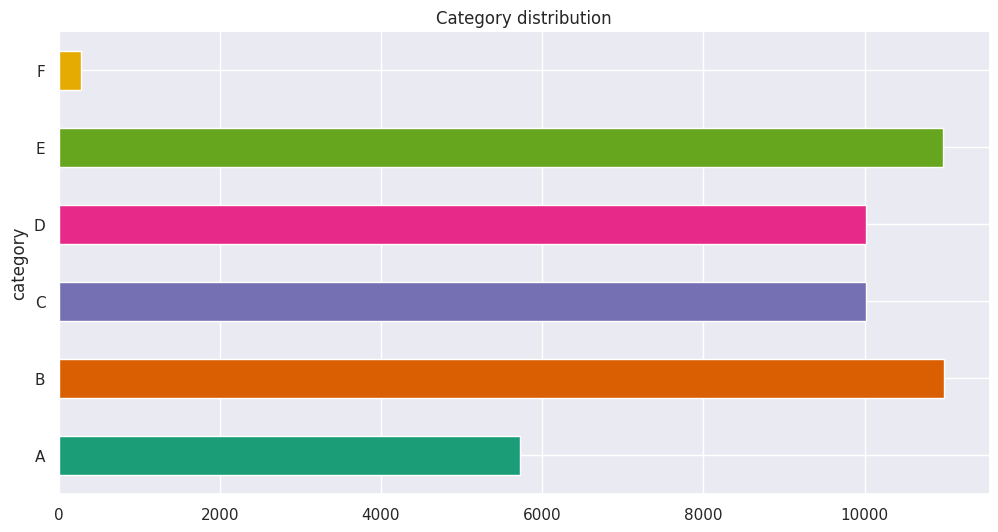

In [10]:
plt.figure(figsize=(12, len(df['category'].unique())))
df.groupby('category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Category distribution');

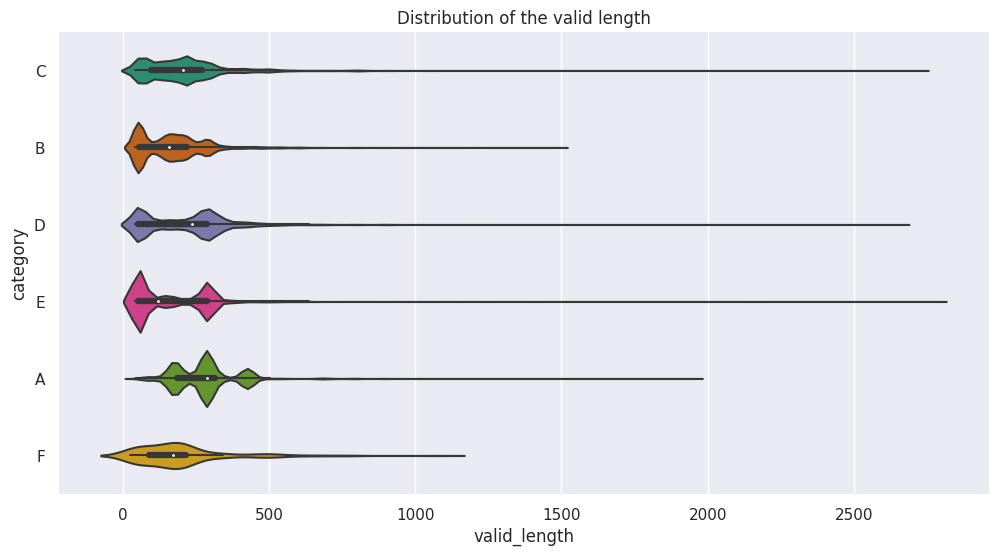

In [16]:
plt.figure(figsize=(12, len(df['category'].unique())))
sns.violinplot(df, x='valid_length', y='category', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.title('Distribution of the valid length');

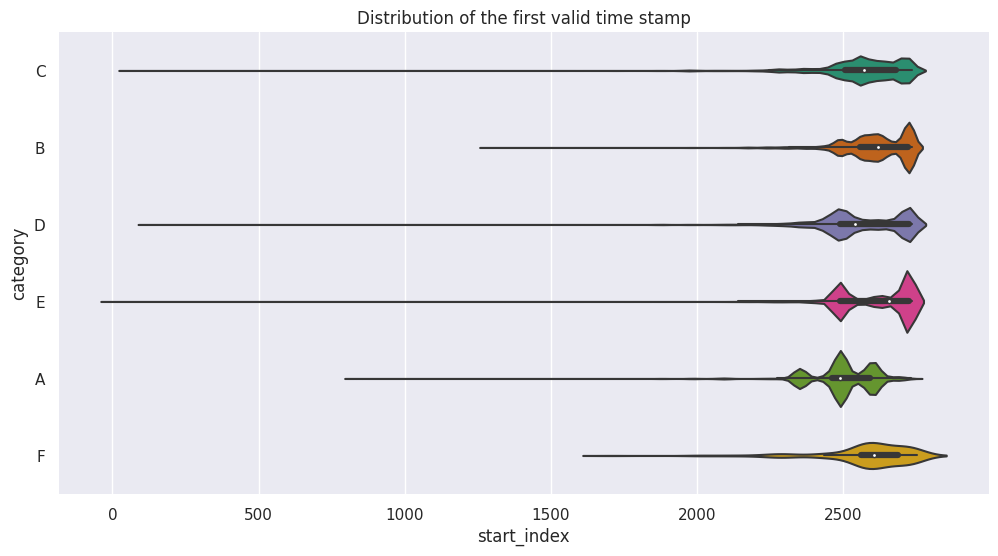

In [ ]:
plt.figure(figsize=(12, len(df['category'].unique())))
sns.violinplot(df, x='start_index', y='category', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.title('Distribution of the first valid time stamp');

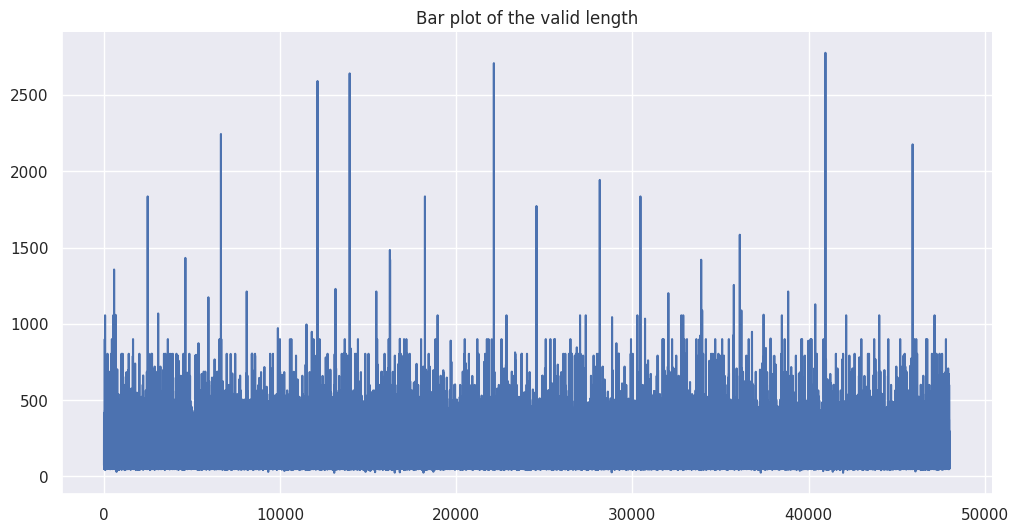

In [ ]:
df['valid_length'].plot(kind='line', figsize=(12, len(df['category'].unique())), title='valid_length')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Bar plot of the valid length');

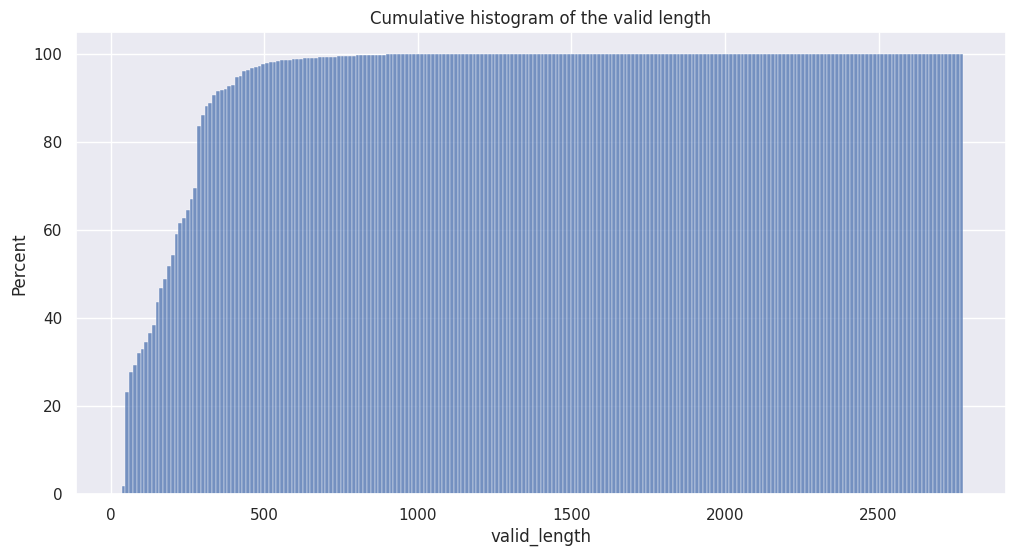

In [ ]:
plt.figure(figsize=(12, len(df['category'].unique())))
sns.histplot(data=df, x="valid_length", stat='percent', cumulative=True)
plt.title('Cumulative histogram of the valid length');

From the plot above, we can see that most of the samples have a valid length of less than 700.  

In [ ]:
np.mean(df["valid_length"]), np.median(df["valid_length"])

(198.30022916666667, 184.0)

The average lenght of a time series is about 200.

In [ ]:
np.min(df["start_index"]), np.min(df["end_index"]), np.min(df["valid_length"])

(0, 2776, 24)

All the values are valid: there are no negative indexes nor sequences with a negative length.

In [ ]:
def plot_time_series(x):
  plt.figure(figsize=(16, 4))
  plt.plot(x)
  plt.title(f"Time series")
  plt.show()

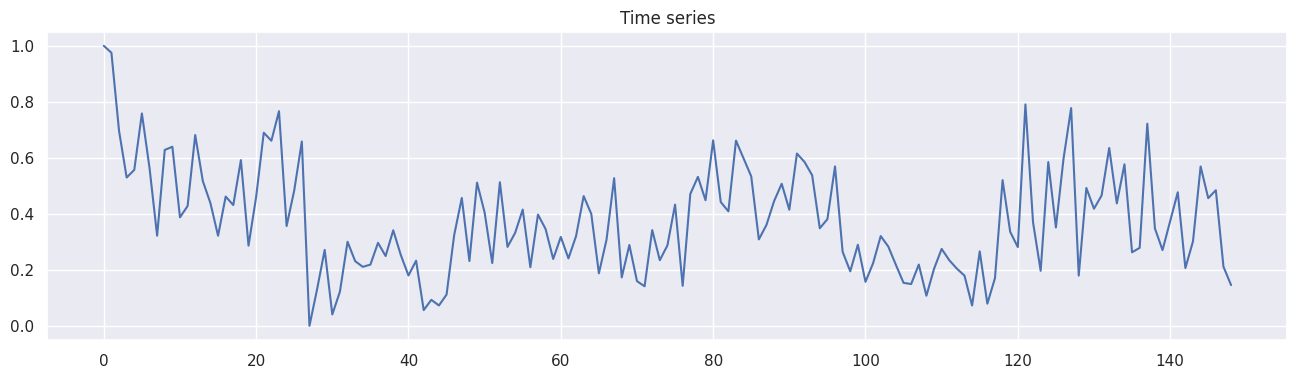

In [ ]:
i = np.random.randint(0, len(training_data))
start_index = valid_periods[i, 0]
plot_time_series(training_data[i, start_index:])

## Data preparation

In [ ]:
sequence_length = training_data.shape[1]
window = 200
stride = 50
telescope = 9

Extract the valid values from each timeseries and store them in a list.

In [ ]:
valid_data = []
for i in trange(len(training_data)):
  start_index = valid_periods[i, 0]
  scaled_data = training_data[i, start_index:]
  valid_data.append(scaled_data)

  0%|          | 0/48000 [00:00<?, ?it/s]

In [ ]:
len(valid_data)

48000

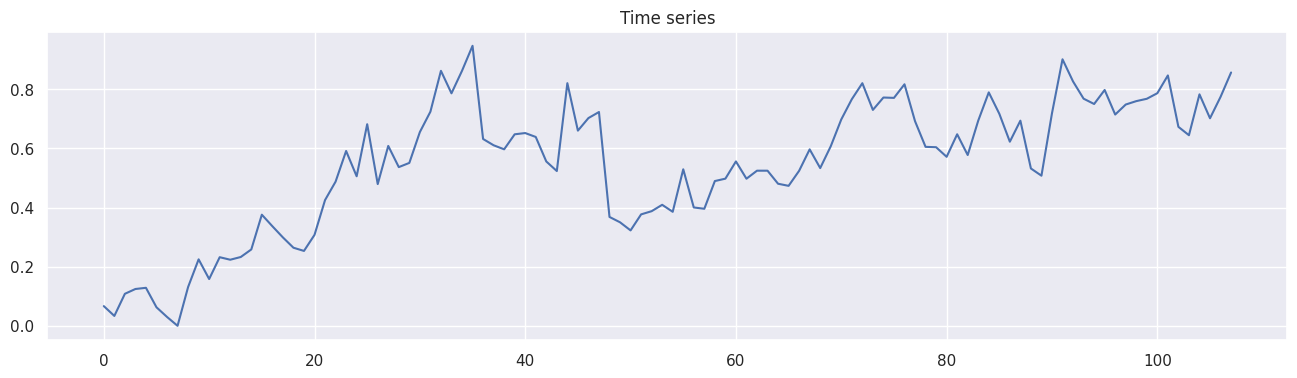

In [ ]:
i = np.random.randint(0, len(valid_data))
plot_time_series(valid_data[i])

In [ ]:
def build_sequences(data, categories, window=200, stride=None, telescope=10):
  stride = stride if stride is not None else window
  new_data = []
  new_targets = []
  new_categories = []

  for timeseries, category in tqdm(zip(data, categories), total=len(data)):
    first_sequence = True
    current_sequence = timeseries[(- window - telescope):]
    end_index = 0

    while (-end_index) <= len(timeseries):
      # Generate as many window as possible from the sequence

      if len(current_sequence) < window + telescope:
        if not first_sequence and len(current_sequence) < stride:
          # If the sequence is too short, just drop it
          break
        else:
          # Pad the sequence to the left
          padding_len = window + telescope - len(current_sequence)
          padding = np.zeros(padding_len)
          current_sequence = np.concatenate([padding, current_sequence])

      # Append to new data
      new_data.append(current_sequence[:window])
      new_targets.append(current_sequence[window:])
      new_categories.append(category)

      # Get the next sequence
      first_sequence = False
      end_index -= stride
      current_sequence = timeseries[(end_index- window - telescope):end_index]

  return np.array(new_data), np.array(new_targets), np.array(new_categories)

In [ ]:
data, targets, categs = build_sequences(valid_data, categories, window=window, stride=stride, telescope=telescope)
data.shape, targets.shape, categs.shape

  0%|          | 0/48000 [00:00<?, ?it/s]

((171419, 200), (171419, 9), (171419,))

In [ ]:
def plot_data_and_target(data, target, original = None):
  # Remove padding from the data
  data = data[np.nonzero(data)[0][0]:]
  # Generate indexes to align the time stamps
  indexes = np.arange(0, len(data) + len(target))

  # Plot the new data and the new target
  plt.figure(figsize=(16, 4))
  plt.plot(indexes[:len(data)], data, label='data', linewidth=3)
  plt.plot(indexes[len(data):], target, label='target', linewidth=3)

  if original is not None:
    # Plot the original data
    plt.plot(indexes, original, label='original', linestyle='--')

  plt.title("Time series")
  plt.legend()
  plt.show()

In [ ]:
valid_data[0].shape, valid_data[1].shape, valid_data[2].shape

((73,), (195,), (163,))

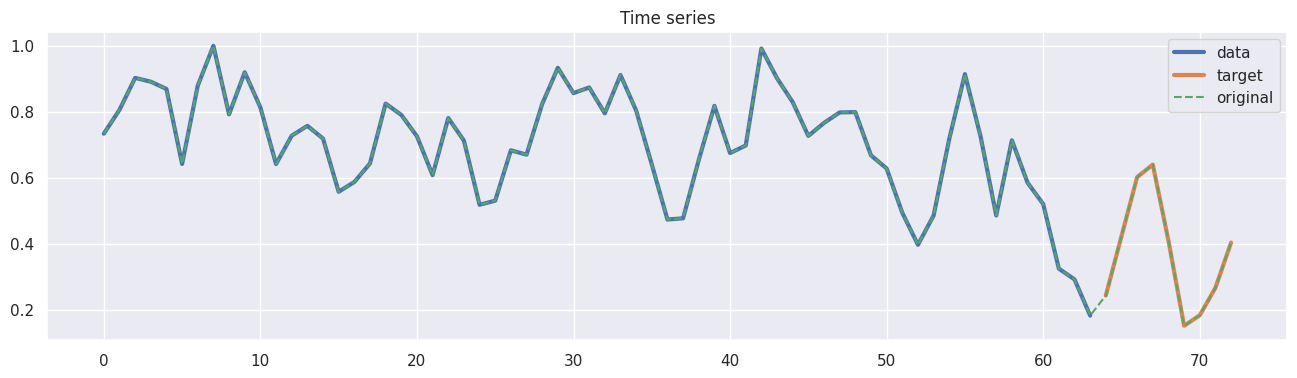

In [ ]:
plot_data_and_target(data[0], targets[0], valid_data[0])

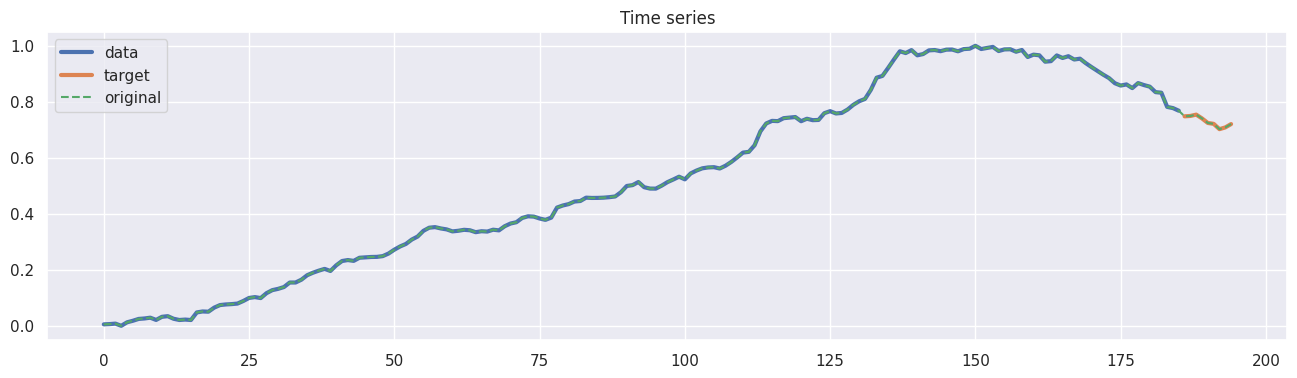

In [ ]:
plot_data_and_target(data[1], targets[1], valid_data[1][0:195])

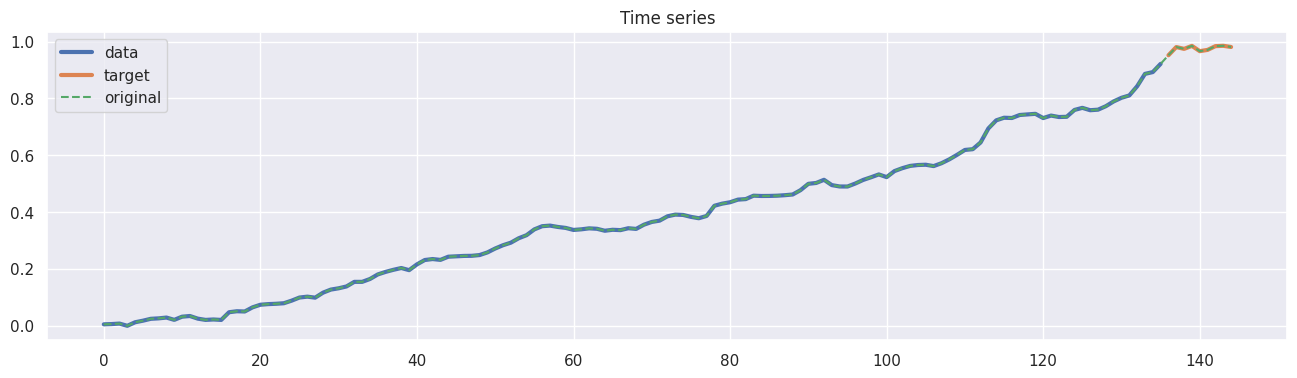

In [ ]:
plot_data_and_target(data[2], targets[2], valid_data[1][0:145])

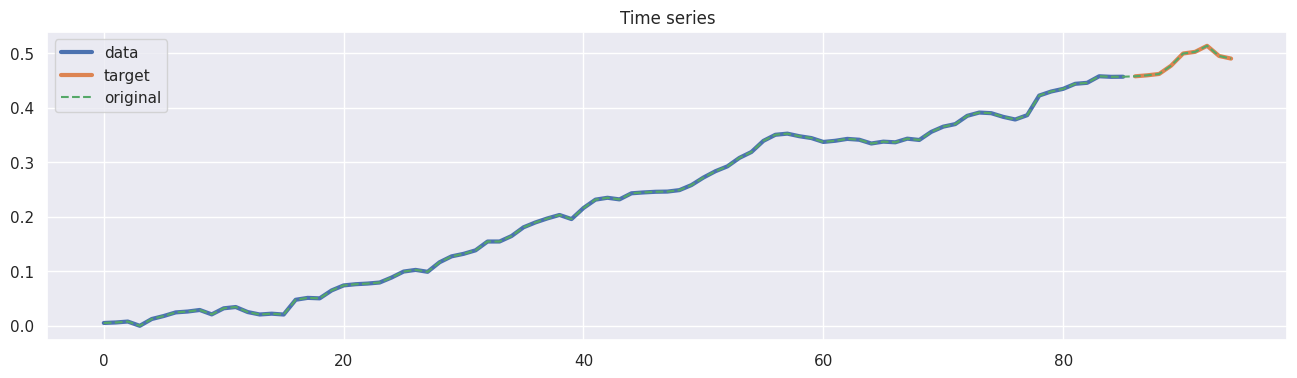

In [ ]:
plot_data_and_target(data[3], targets[3], valid_data[1][0:95])

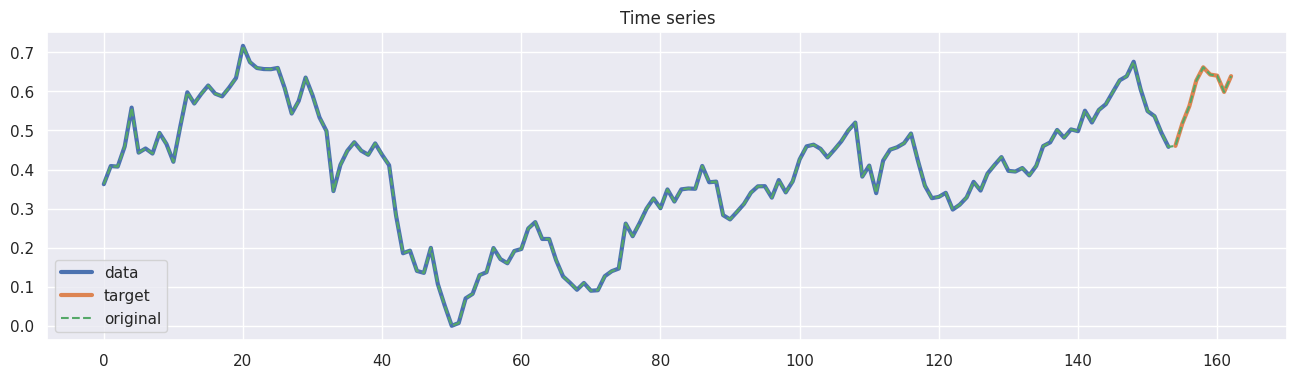

In [ ]:
plot_data_and_target(data[4], targets[4], valid_data[2][0:163])

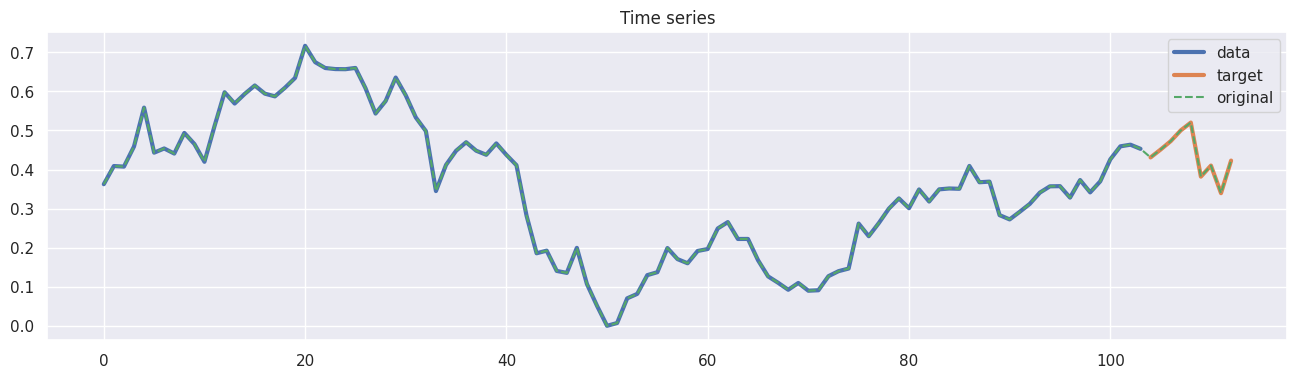

In [ ]:
plot_data_and_target(data[5], targets[5], valid_data[2][0:113])

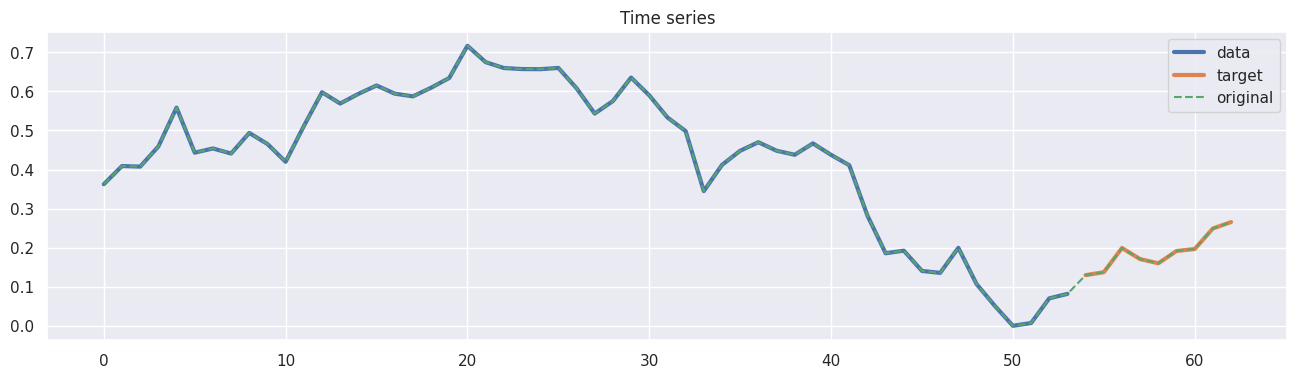

In [ ]:
plot_data_and_target(data[6], targets[6], valid_data[2][0:63])

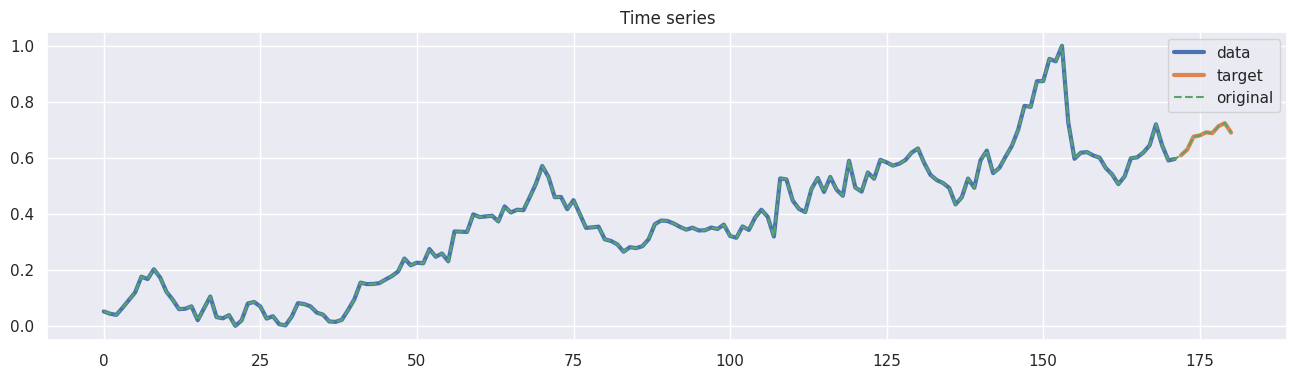

In [ ]:
plot_data_and_target(data[7], targets[7], valid_data[3][0:])

## Train-validation split

In [ ]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(data, targets, random_state=seed, shuffle=True, test_size=0.1, stratify=categs)

In [ ]:
print("Training Data Shape:   ", X_train.shape)
print("Training Label Shape:  ", y_train.shape)
print("Validation Data Shape: ", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape:    (154277, 200)
Training Label Shape:   (154277, 9)
Validation Data Shape:  (17142, 200)
Validation Label Shape: (17142, 9)


In [ ]:
np.savez_compressed(f'preprocessed_data_stride_{stride}.npz', X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)
print("Saved split with seed", seed)

Saved split with seed 42


### Normalization 1

Custom RobustScaler normalization considering all values in the **training** set.

In [ ]:
train_data = np.concatenate([X_train, y_train], axis=1).flatten()

In [ ]:
# Remove padding from the computation
# mask = (train_data != 0.0)
# train_data = train_data[mask]

In [ ]:
median = np.median(train_data)
q1, q3 = np.percentile(train_data, [25, 75])
iqr = q3 - q1
print("Training Data Median:", median)
print("Training Data IQR:", iqr)

Training Data Median: 0.19510793224010892
Training Data IQR: 0.4818731117824773


Rescale both sets using the training set's statistics.

In [ ]:
X_train_1 = (X_train - median) / iqr
y_train_1 = (y_train - median) / iqr
X_val_1 = (X_val - median) / iqr
y_val_1 = (y_val - median) / iqr

Rescale each time series in the range $[0, 1]$.

In [ ]:
rescaled_train = np.concatenate([X_train_1, y_train_1], axis=1)
rescaled_val = np.concatenate([X_val_1, y_val_1], axis=1)

In [ ]:
for i in range(rescaled_train.shape[0]):
  max = rescaled_train[i, :].max()
  min = rescaled_train[i, :].min()
  rescaled_train[i, :] = (rescaled_train[i, :] - min) / (max - min + 1e-12)

In [ ]:
for i in range(rescaled_val.shape[0]):
  max = rescaled_val[i, :].max()
  min = rescaled_val[i, :].min()
  rescaled_val[i, :] = (rescaled_val[i, :] - min) / (max - min + 1e-12)

In [ ]:
X_train_1, y_train_1 = rescaled_train[:, :window], rescaled_train[:, window:]
X_val_1, y_val_1 = rescaled_val[:, :window], rescaled_val[:, window:]

In [ ]:
np.savez_compressed(f'preprocessed_data_stride_{stride}_norm1.npz', X_train=X_train_1, X_val=X_val_1, y_train=y_train_1, y_val=y_val_1)
print("Saved split with seed", seed)

Saved split with seed 42


### Normalization 2

Custom RobustScaler on the dataset's columns (time steps) which does not consider the padded values in the computation of the statistics.

Otherwise, different time steps will end up with a different value for padding, which is not ideal.

In [ ]:
train_data = np.concatenate([X_train, y_train], axis=1)
val_data = np.concatenate([X_val, y_val], axis=1)

In [ ]:
medians = np.zeros(train_data.shape[1])
iqr = np.zeros(train_data.shape[1])

for j in range(train_data.shape[1]):
  h = train_data[:, j]
  h_non_zero = h[h != 0]
  medians[j] = np.median(h_non_zero)
  q1, q3 = np.percentile(h_non_zero, [25, 75])
  iqr[j] = q3 - q1

In [ ]:
medians = medians.reshape(1, -1)
iqr = iqr.reshape(1, -1)

Rescale both sets using the training set's statistics.

In [ ]:
rescaled_train = train_data.copy()
for i in range(rescaled_train.shape[0]):
  try:
    start_index = np.nonzero(rescaled_train[i, :])[0][0]
  except IndexError:
    start_index = 0
  rescaled_train[i, start_index:] -= medians[0,start_index:]
  rescaled_train[i, start_index:] /= iqr[0,start_index:]

In [ ]:
rescaled_val = val_data.copy()
for i in range(rescaled_val.shape[0]):
  try:
    start_index = np.nonzero(rescaled_val[i, :])[0][0]
  except IndexError:
    start_index = 0
  rescaled_val[i, start_index:] -= medians[0,start_index:]
  rescaled_val[i, start_index:] /= iqr[0,start_index:]

Rescale each time series in the range $[0, 1]$.

In [ ]:
for i in range(rescaled_train.shape[0]):
  max = rescaled_train[i, :].max()
  min = rescaled_train[i, :].min()
  rescaled_train[i, :] = (rescaled_train[i, :] - min) / (max - min + 1e-12)

In [ ]:
for i in range(rescaled_val.shape[0]):
  max = rescaled_val[i, :].max()
  min = rescaled_val[i, :].min()
  rescaled_val[i, :] = (rescaled_val[i, :] - min) / (max - min + 1e-12)

In [ ]:
X_train_2, y_train_2 = rescaled_train[:, :window], rescaled_train[:, window:]
X_val_2, y_val_2 = rescaled_val[:, :window], rescaled_val[:, window:]

In [ ]:
np.savez_compressed(f'preprocessed_data_stride_{stride}_norm2.npz', X_train=X_train_2, X_val=X_val_2, y_train=y_train_2, y_val=y_val_2)
print("Saved split with seed", seed)

Saved split with seed 42


## Baseline

To have a baseline on the forescating performance, a simple predictor has been built. It assumes that the timeseries will remain constant.

This method was found to be perform better w.r.t. predicting the average of the timeseries.

In [ ]:
constant_preds = np.repeat(X_val[:, -1:None], telescope, axis=1)
constant_preds.shape

(17142, 9)

In [ ]:
def plot_constant_predictor(data, target, prediction):
  # Remove padding from the data
  data = data[np.nonzero(data)[0][0]:]
  # Generate indexes to align the time stamps
  indexes = np.arange(0, len(data) + len(target))

  # Plot the data and the target
  plt.figure(figsize=(16, 4))
  plt.plot(indexes[:len(data)], data, label='data', linewidth=2)
  plt.plot(indexes[len(data)-1:], np.concatenate([data[-1,None], target]), label='target', linewidth=2)

  # Plot the prediction
  plt.plot(indexes[len(data)-1:], np.concatenate([prediction[0,None], prediction]), label='prediction', linewidth=2)

  plt.title("Constant predictor")
  plt.legend()
  plt.show()

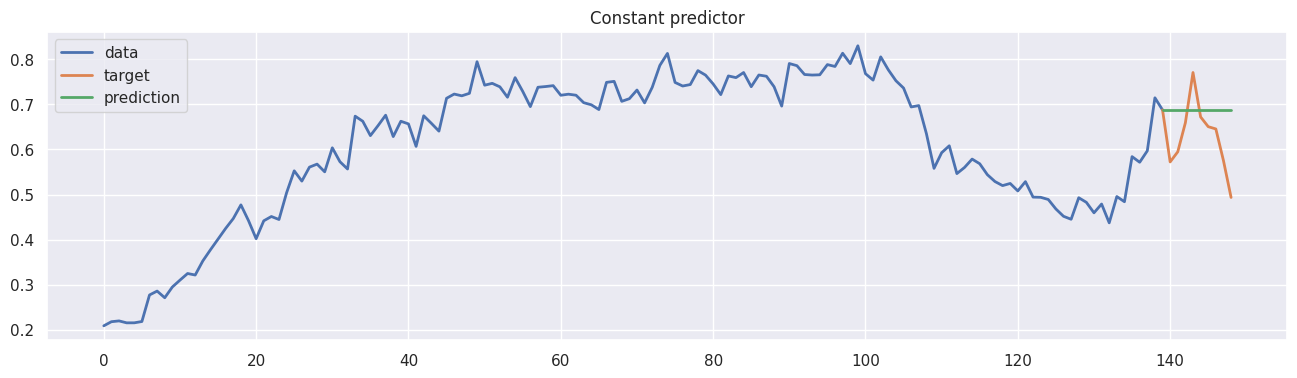

In [ ]:
i = np.random.randint(0, len(X_val))
plot_constant_predictor(X_val[i], y_val[i], constant_preds[i])

In [ ]:
# Calculate and print Mean Squared Error (MSE)
mean_squared_error = mean_squared_error(y_val, constant_preds)
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = mean_absolute_error(y_val, constant_preds)
print(f"Mean Absolute Error: {mean_absolute_error}")

Mean Squared Error: 0.016657167080603177
Mean Absolute Error: 0.08039284709896527
